# Random forest model interpretation on the La Permanence dataset

This follows [Lesson 3](http://course18.fast.ai/lessonsml1/lesson3.html) and [Lesson 4](https://www.youtube.com/watch?v=0v93qHDqq_g) of fastai's [Introduction to Machine Learning for Coders](http://course18.fast.ai/ml).  Link to the [course repository](https://github.com/fastai/fastai/tree/master/courses/ml1).


## Imports

In [1]:
import os
import sys
import re
# import tqdm  # class tqdm.tqdm imported from fastai.structured - see below

import pytz
import datetime

import math
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from scipy.cluster import hierarchy as hc

sys.path.append(os.path.join(os.path.expanduser("~"), "Computing/fastai/old"))
from fastai.structured import *

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Constants

In [2]:
# Timezones
tz_utc = pytz.timezone("UTC")  # timestamp is in UTC standard
tz_paris = pytz.timezone("Europe/Paris")  # locations are in Paris, France

# Resampling rule: resolution of time regularization
RESOL = 10
RULE = f"{RESOL}T"
TWO_WEEKS = 2*7*24*(60 // RESOL)  # validation period is two weeks

# Colors for plotting
# COL_MOULIN = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
# COL_ALESIA = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
COL_TRAIN = plt.rcParams['axes.prop_cycle'].by_key()['color'][2]
COL_VALID = plt.rcParams['axes.prop_cycle'].by_key()['color'][3]
COL_PREDICT = plt.rcParams['axes.prop_cycle'].by_key()['color'][4]

## Helper functions  


In [3]:
def split_vals(df, n):
    return df[:n].copy(), df[n:].copy()
        
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

## Data
The dataset is saved in a `csv` file located in `~/Projects/la_permanence/attendance.csv`.  

**Note**: `attendance.csv` is a misnomer, as the file actually records the number of *available* seats, rather than the number of seats used.  

### Metadata on the dataset

In [4]:
filename = 'attendance.csv'
foldername = 'Projects/la_permanence'
filepath = os.path.join(os.path.expanduser("~"), foldername, filename)
filesize = os.path.getsize(filepath)

COL_WIDTH = 20

if filesize > 1e6:
    print("{0}{1:d}MB".format("File size:".ljust(COL_WIDTH), filesize//int(1e6)))
elif filesize > 1e3:
    print("{0}{1:d}KB".format("File size:".ljust(COL_WIDTH), filesize//int(1e3)))
else:
    print("{0}{1:d}B".format("File size:".ljust(COL_WIDTH), filesize))

line_number = !wc -l < {filepath}
line_number = int(line_number[0])
print("{0}{1}".format("Number of rows:".ljust(COL_WIDTH), line_number))
first_row = !head -1 {filepath}
column_names = first_row[0].split(',')
print("{0}{1}".format("Names of columns:".ljust(COL_WIDTH), ", ".join(column_names)))


File size:          1MB
Number of rows:     41102
Names of columns:   timestamp, Moulin, Alésia


### More details on the columns
-  `timestamp` gives the date and time (UTC) of data collection in the format "YYYY-MM-DD-hh-mm-ss" where
`YYYY=year`,
`MM=month`,
`DD=day`,
`hh=hour`,
`mm=minute`,
`ss=second`;  
-  `Moulin` gives the number of available seats at the rue du Fer à Moulin location (maximum is 63);
-  `Alésia` gives the number of available seats at the rue d'Alésia location (maximum is 82).  

### Load the data

In [5]:
# %%prun
%time
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d-%H-%M-%S')

raw_data = pd.read_csv(
    filepath,
    sep=',',
    dtype={'Moulin': np.uint8, 'Alésia': np.uint8},
    parse_dates=['timestamp'],
    date_parser=dateparse
)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.96 µs


### Adjusting for timezones

The `timestamp` values are in the UTC standard, while the coworking spaces are located in Paris, France:

In [6]:
%time
raw_data['timestamp'] = raw_data['timestamp'].apply(lambda ts: ts.tz_localize(tz_utc).tz_convert(tz_paris))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


### Time regularization

The data is collected at irregular times and thus we resample (at a resolution specified in `RULE`) and interpolate to regularize the data:

In [7]:
raw_data.set_index("timestamp", inplace=True)
raw_data = raw_data.resample(RULE).mean().interpolate().round().astype(np.uint8)
raw_data.reset_index('timestamp', inplace=True)

### Expanding date information

The data is a pure time series: the only independent variable (or feature) is the timestamp.  In order to use random forests, we expand this data into distinct features: `Year`, `Month`, `Week`, `Day`, `Dayofweek`, `Dayofyear`, `Is_month_end`, `Is_month_start`, `Is_quarter_end`, `Is_quarter_start`, `Is_year_end`, `Is_year_start`, `Hour`, `Minute`, `Second`.  Of course, not all of these will be useful or even relevant, and the purpose of this notebook is to measure the relative relevance of these features.  

In [8]:
timestamps = raw_data.loc[:, ['timestamp']]
add_datepart(raw_data, 'timestamp', time=True)

## Rue du Fer à Moulin
We begin with the data from rue du Fer à Moulin.

### Separating dependent from independent variables  

In [9]:
df_trn, y_trn, nas = proc_df(raw_data.drop('Alésia', axis=1), 'Moulin')

### Splitting data into training and validation sets  

In [10]:
n_valid = TWO_WEEKS  
n_trn = raw_data.shape[0] - n_valid

X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(raw_data, n_trn)

# For plotting purposes:
timestamps_train = timestamps.iloc[0:n_trn].copy()
timestamps_valid = timestamps.iloc[n_trn:].copy()

**Note.**  Since the dataset is small, we will use all of it (unlike in the fastai videos where the dataset consists of 400k records).

### Model parameters

For rue du Fer à Moulin, following `la-permanence-random-forests-parameter.ipynb` we set:

In [11]:
nb_trees, min_leaves = 100, 50

Note that we do not fix any value for `max_features` as the purpose of this notebook is to understand the relative importance of the features in the model.

### Train the random forest

In [12]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=nb_trees, min_samples_leaf=min_leaves)
m.fit(X_train, y_train)
print_score(m)

[4.558728740940538, 6.591911054831406, 0.9299023680107288, 0.8844322274799904]


## Feature importance

A useful tool to understand how a model arrives at a particular result is to calculate the **feature importance**:

In [13]:
fi = rf_feat_importance(m, df_trn)

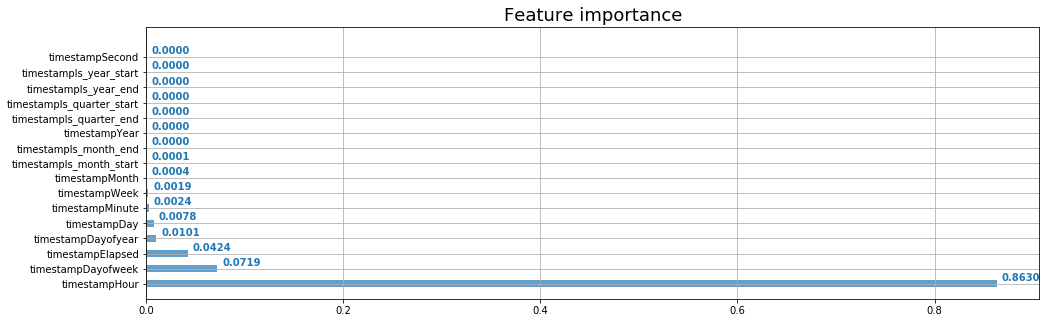

In [14]:
fig, ax = plt.subplots(figsize=(16, 5));
fi.plot('cols', 'imp', 'barh', ax=ax, legend=False, alpha=0.7);
for i, v in enumerate(fi['imp']):
    ax.text(v + .005, i + .2, "{:.4f}".format(v), color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], fontweight='bold');
ax.set_ylim([-1, fi.shape[0]+1])
ax.set_title("Feature importance", fontsize=18);
ax.axes.get_yaxis().label.set_visible(False);
plt.grid();

### First impressions
This table looks mostly as expected and we can interpret these results as follows.  The order of importance may vary from one trial to the next.

- The `Hour` has the highest importance, which is logical as it controls the 24-hour seasonality, the strongest seasonality in the data.  
- The `Dayofweek` has high importance (usually the second highest) as it controls the second strongest seasonality: the 7-day seasonality.  
- The `Elapsed` time has (usually) the next highest importance.  This can be explained by the fact that it picks the general trend in the data, once seasonality is removed.  The `Dayofyear` and the `Day` (of month) follow closely in importance.  This is because they are closely related to the `Elapsed` time given that the timespan of the data is rather short (as of now).  
- The `Week` is also related to the `Elapsed` time, but plays little role as it is a very crude approximation of it.  
- The precise time within an hour (`Minute`) has little importance.  This is perhaps due to the quality of the data: in this particular dataset, data is collected at irregular times and thus regularized and interpolated.  Working with more precise data (collected every minute, say) will probably yield more accurate results, where `Minute` has a higher importance.  
- For such a short timespan, the `Month` features have very little importance.  
- Since the data is all near the beginning of the same year, the features with `Year`, `Is_year_end`, `Is_year_start`, `Is_quarter_end`, `Is_quarter_start` play absolutely no role.  
- The `Second` clearly plays no role as it takes only one value (0).  

In [15]:
to_keep = fi[fi.imp>0.002].cols
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [16]:
m = RandomForestRegressor(n_estimators=nb_trees, min_samples_leaf=min_leaves, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[4.553544798664627, 6.700979361035998, 0.9300616999162779, 0.8805762715790353]


In [17]:
fi = rf_feat_importance(m, df_keep)

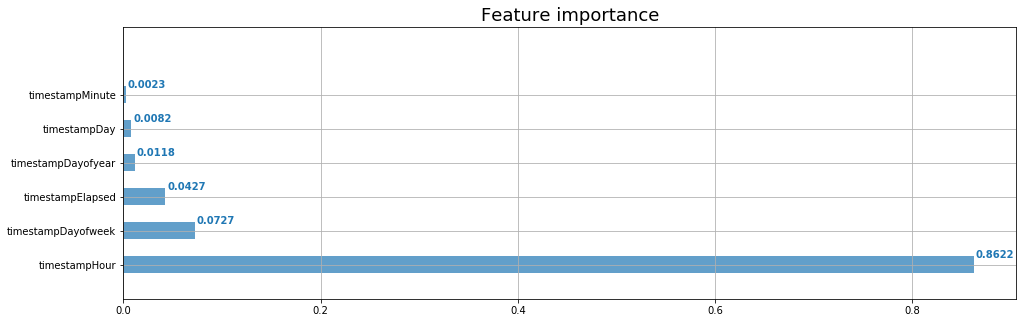

In [18]:
fig, ax = plt.subplots(figsize=(16, 5));
ax.set_title("Feature importance", fontsize=18);
fi.plot('cols', 'imp', 'barh', ax=ax, legend=False, alpha=0.7);
for i, v in enumerate(fi['imp']):
    ax.text(v + .002, i + .2, "{:.4f}".format(v), color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], fontweight='bold');
ax.set_ylim([-1, fi.shape[0]+1])
ax.axes.get_yaxis().label.set_visible(False);
plt.grid();

## Removing redundant features using hierarchical clustering

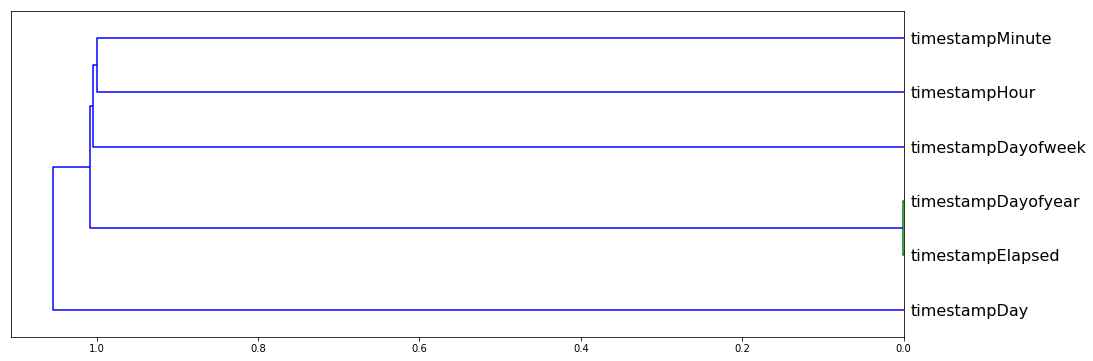

In [19]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1 - corr)
z = hc.linkage(corr_condensed, method='average')

fig = plt.figure(figsize=(16, 6));
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16);

In [20]:
for feat in ['timestampElapsed', 'timestampDayofyear']:
    m = RandomForestRegressor(n_jobs=-1, n_estimators=nb_trees, min_samples_leaf=min_leaves)
    x, _ = split_vals(df_keep.drop(feat, axis=1), n_trn)
    m.fit(x, y_train)
    print("Score with {0} removed: {1}".format(feat.ljust(18), m.score(X_valid.drop(feat, axis=1), y_valid)))

Score with timestampElapsed   removed: 0.8914697544692658
Score with timestampDayofyear removed: 0.8822006828408545


The difference is very small, but the score with `timestampElapsed` removed is consistently better than that with `Dayofyear` removed.  This is a bit counter-intuitive as its importance is definitely higher.